In [ ]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid


In [ ]:
dataset_path = './datasets'

DEVICE = torch.device( "cpu")
batch_size = 100

x_dim = 784
hidden_dim = 400
latent_dim = 20

lr = 1e-3
num_epochs = 100

In [14]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
    transforms.ToTensor(), # [0, 255] -> [0, 1]
])

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

train_dataset = MNIST(dataset_path, train=True, transform=mnist_transform, download=True)
test_dataset = MNIST(dataset_path, train=False, transform=mnist_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

canais_img = train_dataset[0][0].shape[0]
input_channels = canais_img
print(f'Número de canais da imagem: {canais_img}')

# Acessando o primeiro item do dataset
amostra_x, rotulo = train_dataset[0]

# Extraindo dimensões
canais = amostra_x.shape[0]
altura = amostra_x.shape[1]
largura = amostra_x.shape[2]

print(f"--- Info da Amostra ---")
print(f"Dimensões da Imagem: {canais} canais x {altura}px x {largura}px")
print(f"Rótulo (Label): {rotulo}") 

Número de canais da imagem: 1
--- Info da Amostra ---
Dimensões da Imagem: 1 canais x 28px x 28px
Rótulo (Label): 5


In [15]:
# '''
# implementation of Gaussian MLP 
# '''

# class Encoder(nn.Module):
#     def __init__(self, x_dim, hidden_dim, latent_dim):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(x_dim, hidden_dim) #ax + b
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc3_mean = nn.Linear(hidden_dim, latent_dim)
#         self.fc3_logvar = nn.Linear(hidden_dim, latent_dim)

#         self.LeakyReLU = nn.LeakyReLU(0.2) # ela evita o problema de gradiente nulo, mesmo quando a entrada é negativa, o que pode ocorrer durante o treinamento.


#         self.training = True
    
#     def forward(self, x):
#         h_ = self.LeakyReLU(self.fc1(x))
#         h_ = self.LeakyReLU(self.fc2(h_))
#         mean = self.fc3_mean(h_)
#         logvar = self.fc3_logvar(h_)
#         return mean, logvar

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Encoder, self).__init__()
        
        # 1. Camadas Convolucionais para extração de features espaciais
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1), # Saída: 14x14
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),            # Saída: 7x7
            nn.LeakyReLU(0.2),
            nn.Flatten() # Transforma o volume (64, 7, 7) em um vetor único
        )
        
        # Precisamos calcular o tamanho da entrada após o flatten
        # Para uma imagem 28x28 com 2 strides, chegamos a 7x7. 64 canais * 7 * 7 = 3136
        flat_features = 64 * 7 * 7 
        
        # 2. Camadas Lineares para os parâmetros da Gaussiana
        self.fc_mean = nn.Linear(flat_features, latent_dim)
        self.fc_logvar = nn.Linear(flat_features, latent_dim)

    def forward(self, x):
        # x deve ter o shape [Batch, Channels, Height, Width]
        h_ = self.conv_layers(x)
        
        mean = self.fc_mean(h_)
        logvar = self.fc_logvar(h_)
        
        return mean, logvar

In [17]:
# class Decoder(nn.Module):
#     def __init__(self, latent_dim, hidden_dim, y_dim):
#         super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(latent_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc3 = nn.Linear(hidden_dim, y_dim)

#         self.LeakyReLU = nn.LeakyReLU(0.2)
    
#     def forward(self, z):
#         h = self.LeakyReLU(self.fc1(z))
#         h = self.LeakyReLU(self.fc2(h))
#         y_hat = torch.sigmoid(self.fc3(h))
#         return y_hat

In [18]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels):
        super(Decoder, self).__init__()
        
        # 1. Expandir o vetor latente de volta para a dimensão do último mapa de features
        # No Encoder era (64, 7, 7), então flat_features = 3136
        self.fc_upsample = nn.Linear(latent_dim, 64 * 7 * 7)
        
        # 2. Camadas de Convolução Transposta (Upsampling)
        self.deconv_layers = nn.Sequential(
            # Entrada: [Batch, 64, 7, 7]
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            # Saída: [Batch, 32, 14, 14]
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(32, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            # Saída: [Batch, output_channels, 28, 28]
            nn.Sigmoid() # Garante que os pixels estejam entre 0 e 1
        )

    def forward(self, z):
        # Transforma o vetor latente em um vetor "largo"
        h = self.fc_upsample(z)
        
        # Faz o "Reshape" para o formato de volume (Batch, Channels, Height, Width)
        # Isso é o inverso do Flatten()
        h = h.view(-1, 64, 7, 7)
        
        # Passa pelas camadas de expansão espacial
        y_hat = self.deconv_layers(h)
        
        return y_hat

In [19]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    def reparameterize(self, mean, logvar):
        dp = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(dp).to(DEVICE)
        z = mean + dp * epsilon
        return z
    
    def forward(self, x):
        mean, logvar = self.Encoder(x)
        z = self.reparameterize(mean, logvar)
        y_hat = self.Decoder(z)
        return y_hat, mean, logvar
    

In [20]:
# encoder = Encoder(x_dim, hidden_dim, latent_dim)
# decoder = Decoder(latent_dim, hidden_dim, x_dim)

encoder = Encoder(input_channels, latent_dim)
decoder = Decoder(latent_dim, input_channels)

model = Model(encoder, decoder).to(DEVICE)
print("model: ", model)

model:  Model(
  (Encoder): Encoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.2)
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mean): Linear(in_features=3136, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=3136, out_features=20, bias=True)
  )
  (Decoder): Decoder(
    (fc_upsample): Linear(in_features=20, out_features=3136, bias=True)
    (deconv_layers): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (3): Sigmoid()
    )
  )
)


In [21]:
from torch.optim import Adam

# BCE_loss = nn.BCELoss()
# nn.functional.binary_cross_entropy(y_hat, x, reduction='sum')

def loss_(x, y_hat, mean, logvar):
    reproduction_loss = -torch.sum(x * torch.log(y_hat + 1e-10) + (1 - x) * torch.log(1 - y_hat + 1e-10))
    DKL = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return reproduction_loss + DKL

optimizer = Adam(model.parameters(), lr=lr)

In [22]:
print("Starting training VAE...")
model.train()

for epoch in range(num_epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(tqdm(train_loader)):
        x = x.view(-1, input_channels, altura, largura).to(DEVICE) # Garantindo que x tenha o formato correto para o Encoder

        optimizer.zero_grad()

        y_hat, mean, logvar = model(x)

        # Printando a média e o logvar do primeiro item do batch
        if batch_idx == 0: # Printa apenas no primeiro batch para não inundar a tela
            print(f"Média (primeiros 5 valores do vetor): {mean[0][:5].detach().cpu().numpy()}")
            print(f"LogVar (primeiros 5 valores do vetor): {logvar[0][:5].detach().cpu().numpy()}")

        loss = loss_(x, y_hat, mean, logvar)

        overall_loss += loss.item()
        loss.backward()
        optimizer.step()

        # print("\tEpoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
        #     epoch, batch_idx * len(x), len(train_loader.dataset),
        #     100. * batch_idx / len(train_loader), overall_loss / len(train_loader.dataset)))
        # print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / ((batch_idx+1)*batch_size))
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / ((batch_idx+1)*batch_size))
print("Finish!!")

Starting training VAE...


  0%|          | 1/600 [00:00<05:33,  1.80it/s]

Média (primeiros 5 valores do vetor): [-0.05023194  0.04083715 -0.04723622 -0.06797978 -0.00093195]
LogVar (primeiros 5 valores do vetor): [ 0.03430173  0.02550561  0.07250302  0.02032515 -0.00804742]


100%|██████████| 600/600 [00:36<00:00, 16.60it/s]


	Epoch 1 complete! 	Average Loss:  149.5462687825521


  0%|          | 2/600 [00:00<00:43, 13.66it/s]

Média (primeiros 5 valores do vetor): [-0.5021293   0.85388625 -1.7297829  -0.6572191  -0.04512845]
LogVar (primeiros 5 valores do vetor): [-2.4881222 -2.715197  -3.17086   -2.283588  -1.923095 ]


100%|██████████| 600/600 [00:29<00:00, 20.52it/s]


	Epoch 2 complete! 	Average Loss:  118.75140232747395


  0%|          | 3/600 [00:00<00:28, 20.83it/s]

Média (primeiros 5 valores do vetor): [ 1.0675899   1.6500477   2.285787    0.51349837 -0.11952026]
LogVar (primeiros 5 valores do vetor): [-2.2704692 -3.0569744 -3.2468214 -2.6088243 -2.7300053]


100%|██████████| 600/600 [00:30<00:00, 19.89it/s]


	Epoch 3 complete! 	Average Loss:  112.77662469075521


  0%|          | 2/600 [00:00<00:31, 19.09it/s]

Média (primeiros 5 valores do vetor): [-0.21904129  0.3034201   0.16499625  0.9049817   0.06953348]
LogVar (primeiros 5 valores do vetor): [-3.2321877 -3.3872643 -4.050376  -2.5938554 -2.1392202]


100%|██████████| 600/600 [00:29<00:00, 20.65it/s]


	Epoch 4 complete! 	Average Loss:  109.68141767578125


  0%|          | 2/600 [00:00<00:32, 18.12it/s]

Média (primeiros 5 valores do vetor): [-0.58470273  1.0791079  -0.9762831  -0.12638937  0.39729846]
LogVar (primeiros 5 valores do vetor): [-1.8667417 -2.2616856 -3.4504776 -1.6692073 -1.1089754]


100%|██████████| 600/600 [00:29<00:00, 20.50it/s]


	Epoch 5 complete! 	Average Loss:  108.011342578125


  0%|          | 2/600 [00:00<00:30, 19.54it/s]

Média (primeiros 5 valores do vetor): [-0.2667677   0.10488342 -0.6721265   1.6140205  -0.8398901 ]
LogVar (primeiros 5 valores do vetor): [-2.663437  -3.3065355 -3.9646769 -2.158536  -1.7134173]


100%|██████████| 600/600 [00:29<00:00, 20.13it/s]


	Epoch 6 complete! 	Average Loss:  107.01805675455729


  0%|          | 3/600 [00:00<00:29, 20.55it/s]

Média (primeiros 5 valores do vetor): [-1.6759259   1.6189184  -0.5327494  -0.73340213 -0.60451627]
LogVar (primeiros 5 valores do vetor): [-2.9144902 -3.5192597 -4.5336986 -2.1641195 -1.6193621]


100%|██████████| 600/600 [00:29<00:00, 20.46it/s]


	Epoch 7 complete! 	Average Loss:  106.2606779296875


  0%|          | 3/600 [00:00<00:28, 20.74it/s]

Média (primeiros 5 valores do vetor): [-2.0278108  -0.54757774  0.86707896  0.2527835  -0.55127877]
LogVar (primeiros 5 valores do vetor): [-2.6350274 -3.581818  -4.475502  -2.2866094 -2.1833029]


100%|██████████| 600/600 [00:28<00:00, 20.69it/s]


	Epoch 8 complete! 	Average Loss:  105.64769664713542


  0%|          | 3/600 [00:00<00:29, 20.48it/s]

Média (primeiros 5 valores do vetor): [-0.93097425  0.61672413  1.8327218  -0.49401766  0.8423388 ]
LogVar (primeiros 5 valores do vetor): [-2.9336042 -3.2165565 -4.038859  -2.3489738 -1.699312 ]


100%|██████████| 600/600 [00:29<00:00, 20.65it/s]


	Epoch 9 complete! 	Average Loss:  105.10146155598959


  0%|          | 2/600 [00:00<00:30, 19.64it/s]

Média (primeiros 5 valores do vetor): [-0.24911475 -2.3974345   0.02465747  1.0004241  -0.5806761 ]
LogVar (primeiros 5 valores do vetor): [-2.8158536 -3.2430155 -4.4412217 -2.1258    -1.4440647]


100%|██████████| 600/600 [00:29<00:00, 20.00it/s]


	Epoch 10 complete! 	Average Loss:  104.67071051432292


  0%|          | 2/600 [00:00<00:31, 19.28it/s]

Média (primeiros 5 valores do vetor): [-1.8880665  -0.60706884  0.58068025  1.1211944  -0.7913824 ]
LogVar (primeiros 5 valores do vetor): [-3.2339306 -3.6605973 -4.6087456 -2.4035149 -2.4237564]


100%|██████████| 600/600 [00:28<00:00, 20.85it/s]


	Epoch 11 complete! 	Average Loss:  104.32721796875


  0%|          | 2/600 [00:00<00:31, 19.26it/s]

Média (primeiros 5 valores do vetor): [ 0.79106975 -1.891747    0.72353745 -2.8325953   1.8728111 ]
LogVar (primeiros 5 valores do vetor): [-2.9261656 -3.7199957 -4.4329834 -2.0618143 -1.4391847]


100%|██████████| 600/600 [00:28<00:00, 20.86it/s]


	Epoch 12 complete! 	Average Loss:  103.94124339192709


  0%|          | 3/600 [00:00<00:29, 20.22it/s]

Média (primeiros 5 valores do vetor): [ 0.43345746  0.45167357  1.2165256  -0.7377845   0.0912476 ]
LogVar (primeiros 5 valores do vetor): [-2.6710503 -3.8747642 -4.9433775 -1.4219992 -1.2247483]


100%|██████████| 600/600 [00:29<00:00, 20.21it/s]


	Epoch 13 complete! 	Average Loss:  103.65108846028646


  0%|          | 2/600 [00:00<00:32, 18.29it/s]

Média (primeiros 5 valores do vetor): [ 0.16193393 -1.4671582  -0.6547879  -0.67028755  0.7021047 ]
LogVar (primeiros 5 valores do vetor): [-2.7636976 -3.655891  -4.402165  -1.2765932 -1.1582257]


100%|██████████| 600/600 [00:30<00:00, 19.89it/s]


	Epoch 14 complete! 	Average Loss:  103.33782194010416


  0%|          | 2/600 [00:00<00:29, 19.95it/s]

Média (primeiros 5 valores do vetor): [ 0.6093302 -1.4161373  0.6420188 -1.0468433  1.710321 ]
LogVar (primeiros 5 valores do vetor): [-2.5290573 -3.6206741 -4.4732323 -2.1481624 -1.583336 ]


100%|██████████| 600/600 [00:31<00:00, 19.10it/s]


	Epoch 15 complete! 	Average Loss:  103.18996707356771


  1%|          | 4/600 [00:00<00:50, 11.91it/s]

Média (primeiros 5 valores do vetor): [-1.1120749   0.2531368  -1.04928     0.01991818 -0.2128075 ]
LogVar (primeiros 5 valores do vetor): [-1.7365649  -3.107359   -3.8338492  -0.72387683 -0.56283593]


100%|██████████| 600/600 [00:31<00:00, 19.32it/s]


	Epoch 16 complete! 	Average Loss:  102.94153011067708


  0%|          | 1/600 [00:00<01:43,  5.79it/s]

Média (primeiros 5 valores do vetor): [ 0.44161072 -0.79528797 -0.48679128  0.04924536  0.04529864]
LogVar (primeiros 5 valores do vetor): [-3.1283922 -3.965209  -4.811197  -2.1675878 -1.8683715]


100%|██████████| 600/600 [00:30<00:00, 19.73it/s]


	Epoch 17 complete! 	Average Loss:  102.74437633463542


  0%|          | 2/600 [00:00<00:35, 16.80it/s]

Média (primeiros 5 valores do vetor): [ 1.237675    1.4729294  -0.190482    0.5796763   0.25312608]
LogVar (primeiros 5 valores do vetor): [-2.4421883 -3.6478677 -4.577527  -1.9131427 -1.3222774]


100%|██████████| 600/600 [00:29<00:00, 20.11it/s]


	Epoch 18 complete! 	Average Loss:  102.54250462239584


  0%|          | 2/600 [00:00<00:35, 16.69it/s]

Média (primeiros 5 valores do vetor): [0.9524783  0.52734476 0.22478807 0.41339228 0.42353824]
LogVar (primeiros 5 valores do vetor): [-2.9160662 -4.1965885 -4.8587227 -2.0261557 -1.5446302]


100%|██████████| 600/600 [00:29<00:00, 20.47it/s]


	Epoch 19 complete! 	Average Loss:  102.38293131510417


  0%|          | 1/600 [00:00<01:41,  5.93it/s]

Média (primeiros 5 valores do vetor): [-2.8194804   0.86726236  1.0265493  -1.554832   -0.6412992 ]
LogVar (primeiros 5 valores do vetor): [-2.6944518 -3.3791904 -3.9980009 -1.5256197 -1.3978853]


100%|██████████| 600/600 [00:29<00:00, 20.13it/s]


	Epoch 20 complete! 	Average Loss:  102.25816100260417


  0%|          | 2/600 [00:00<00:37, 16.14it/s]

Média (primeiros 5 valores do vetor): [ 0.3908273   0.5441824  -1.37058     0.23801628 -0.29981494]
LogVar (primeiros 5 valores do vetor): [-1.8197207  -2.7710457  -3.917552   -0.5724912  -0.32232141]


100%|██████████| 600/600 [00:29<00:00, 20.19it/s]


	Epoch 21 complete! 	Average Loss:  102.0711796875


  0%|          | 2/600 [00:00<00:34, 17.18it/s]

Média (primeiros 5 valores do vetor): [ 0.11705807  0.75114226 -2.013435    0.10979631 -0.37894   ]
LogVar (primeiros 5 valores do vetor): [-2.2627616 -3.1248362 -3.597259  -1.2497475 -0.8192986]


100%|██████████| 600/600 [00:29<00:00, 20.36it/s]


	Epoch 22 complete! 	Average Loss:  101.97266783854167


  0%|          | 2/600 [00:00<00:35, 16.90it/s]

Média (primeiros 5 valores do vetor): [ 0.39353603  1.3992653  -0.8040606   0.58436066  0.22223172]
LogVar (primeiros 5 valores do vetor): [-2.3838496 -3.5887694 -4.8021355 -1.6398753 -1.287581 ]


100%|██████████| 600/600 [00:29<00:00, 20.16it/s]


	Epoch 23 complete! 	Average Loss:  101.81957392578126


  0%|          | 2/600 [00:00<00:38, 15.65it/s]

Média (primeiros 5 valores do vetor): [ 2.2356997  -0.63926244 -0.08244848 -0.00949192 -1.799131  ]
LogVar (primeiros 5 valores do vetor): [-2.3135207 -4.3971863 -5.096887  -1.809231  -1.3351524]


100%|██████████| 600/600 [00:30<00:00, 19.92it/s]


	Epoch 24 complete! 	Average Loss:  101.71972403971354


  0%|          | 2/600 [00:00<00:35, 16.94it/s]

Média (primeiros 5 valores do vetor): [-0.50827944  0.11709242 -0.6457968  -2.3021574  -1.5794678 ]
LogVar (primeiros 5 valores do vetor): [-2.771101  -3.768249  -4.350746  -1.7875236 -1.825273 ]


100%|██████████| 600/600 [00:29<00:00, 20.63it/s]


	Epoch 25 complete! 	Average Loss:  101.56253600260416


  0%|          | 2/600 [00:00<00:34, 17.23it/s]

Média (primeiros 5 valores do vetor): [-0.51325107  0.49367568 -0.43658245 -0.19726516 -0.19368078]
LogVar (primeiros 5 valores do vetor): [-2.63724   -3.5253284 -4.6759043 -1.6730754 -1.4048636]


100%|██████████| 600/600 [00:29<00:00, 20.53it/s]


	Epoch 26 complete! 	Average Loss:  101.49380138346355


  0%|          | 2/600 [00:00<00:36, 16.52it/s]

Média (primeiros 5 valores do vetor): [-0.51587594  1.7305431   0.8968029  -0.24067476  0.20177889]
LogVar (primeiros 5 valores do vetor): [-2.5931354 -4.050088  -4.5202494 -1.9252374 -1.5447316]


100%|██████████| 600/600 [00:29<00:00, 20.38it/s]


	Epoch 27 complete! 	Average Loss:  101.41277412109375


  0%|          | 1/600 [00:00<01:44,  5.71it/s]

Média (primeiros 5 valores do vetor): [ 0.31355333 -0.08123615  0.10845052  0.52513075  1.2954359 ]
LogVar (primeiros 5 valores do vetor): [-2.4375374 -4.0129404 -4.692491  -1.5311358 -1.4201257]


100%|██████████| 600/600 [00:29<00:00, 20.52it/s]


	Epoch 28 complete! 	Average Loss:  101.3067302734375


  0%|          | 2/600 [00:00<00:34, 17.13it/s]

Média (primeiros 5 valores do vetor): [ 0.34769207  0.87878704 -0.68983173 -0.52010524  0.06950647]
LogVar (primeiros 5 valores do vetor): [-2.1243024 -3.7582502 -4.3520675 -1.2579463 -1.7517862]


100%|██████████| 600/600 [00:29<00:00, 20.47it/s]


	Epoch 29 complete! 	Average Loss:  101.23487963867187


  0%|          | 2/600 [00:00<00:34, 17.27it/s]

Média (primeiros 5 valores do vetor): [-0.35969868 -1.8385525   0.40869588  0.3923341   0.06413402]
LogVar (primeiros 5 valores do vetor): [-2.5840435 -3.570994  -4.954568  -1.1960582 -0.959571 ]


100%|██████████| 600/600 [00:29<00:00, 20.42it/s]


	Epoch 30 complete! 	Average Loss:  101.14230475260416


  0%|          | 2/600 [00:00<00:34, 17.33it/s]

Média (primeiros 5 valores do vetor): [ 0.71833515  2.57866    -0.71054107  0.8022493  -0.5237631 ]
LogVar (primeiros 5 valores do vetor): [-2.4363148 -3.337234  -4.7476687 -1.3558915 -0.7738251]


100%|██████████| 600/600 [00:29<00:00, 20.59it/s]


	Epoch 31 complete! 	Average Loss:  101.01877626953124


  0%|          | 2/600 [00:00<00:34, 17.13it/s]

Média (primeiros 5 valores do vetor): [-0.94701356 -0.7227391  -0.3815313   1.2231762  -0.30623513]
LogVar (primeiros 5 valores do vetor): [-3.0842462 -3.6322112 -4.5106535 -2.0191703 -1.2911768]


100%|██████████| 600/600 [00:29<00:00, 20.65it/s]


	Epoch 32 complete! 	Average Loss:  100.93638430989583


  0%|          | 2/600 [00:00<00:34, 17.44it/s]

Média (primeiros 5 valores do vetor): [ 0.8281337  -0.49933004 -1.9621017  -0.26569417 -0.73870647]
LogVar (primeiros 5 valores do vetor): [-2.2227714 -4.0735598 -4.4729185 -1.2259588 -0.8737894]


100%|██████████| 600/600 [00:29<00:00, 20.39it/s]


	Epoch 33 complete! 	Average Loss:  100.90268138020834


  0%|          | 2/600 [00:00<00:35, 16.96it/s]

Média (primeiros 5 valores do vetor): [-0.06971796  1.5711508  -0.5409327  -0.7450003  -0.23968568]
LogVar (primeiros 5 valores do vetor): [-2.4350162 -3.8701565 -5.356067  -1.5945761 -1.2912655]


100%|██████████| 600/600 [00:29<00:00, 20.33it/s]


	Epoch 34 complete! 	Average Loss:  100.81028271484375


  0%|          | 2/600 [00:00<00:33, 17.84it/s]

Média (primeiros 5 valores do vetor): [-0.42459944  0.29980317 -0.21837923  0.3304203  -0.8448988 ]
LogVar (primeiros 5 valores do vetor): [-1.7907137  -3.2178197  -4.792842   -0.70466036 -0.43545994]


100%|██████████| 600/600 [00:29<00:00, 20.35it/s]


	Epoch 35 complete! 	Average Loss:  100.72373844401042


  0%|          | 2/600 [00:00<00:36, 16.53it/s]

Média (primeiros 5 valores do vetor): [ 0.17257571 -1.222076   -0.5382813  -0.906024   -1.1405013 ]
LogVar (primeiros 5 valores do vetor): [-2.5653982 -3.9538832 -4.2836075 -1.5334151 -0.9012767]


100%|██████████| 600/600 [00:29<00:00, 20.40it/s]


	Epoch 36 complete! 	Average Loss:  100.67994682617187


  0%|          | 2/600 [00:00<00:37, 15.95it/s]

Média (primeiros 5 valores do vetor): [-0.6460365   0.456983    0.69678026  0.01985253  0.9272699 ]
LogVar (primeiros 5 valores do vetor): [-2.670835  -3.9695313 -4.827942  -1.9786763 -1.4830555]


100%|██████████| 600/600 [00:29<00:00, 20.40it/s]


	Epoch 37 complete! 	Average Loss:  100.60925802408855


  0%|          | 2/600 [00:00<00:35, 16.77it/s]

Média (primeiros 5 valores do vetor): [-0.16823438 -2.3280993  -0.6541266  -0.03215578  1.0292656 ]
LogVar (primeiros 5 valores do vetor): [-2.749528  -3.897525  -4.7711296 -1.8274081 -1.1255987]


100%|██████████| 600/600 [00:29<00:00, 20.66it/s]


	Epoch 38 complete! 	Average Loss:  100.60561697591146


  0%|          | 2/600 [00:00<00:40, 14.86it/s]

Média (primeiros 5 valores do vetor): [ 0.3835742  -1.4097352  -0.50943774  0.8293518  -0.07131373]
LogVar (primeiros 5 valores do vetor): [-2.7625718  -4.0889826  -4.7998567  -1.4882898  -0.97220486]


100%|██████████| 600/600 [00:29<00:00, 20.59it/s]


	Epoch 39 complete! 	Average Loss:  100.48887024739584


  0%|          | 2/600 [00:00<00:35, 16.71it/s]

Média (primeiros 5 valores do vetor): [ 1.0644846   1.2736186   1.0415863   0.41852129 -0.5199537 ]
LogVar (primeiros 5 valores do vetor): [-2.6821737  -3.84028    -4.9758463  -1.6551378  -0.95052516]


100%|██████████| 600/600 [00:29<00:00, 20.35it/s]


	Epoch 40 complete! 	Average Loss:  100.39485927734376


  0%|          | 2/600 [00:00<00:36, 16.42it/s]

Média (primeiros 5 valores do vetor): [-1.1184888  -0.17002669  0.53972965 -1.0999937  -0.19923918]
LogVar (primeiros 5 valores do vetor): [-2.6001344 -3.776369  -4.454306  -1.5521271 -1.1049001]


100%|██████████| 600/600 [00:29<00:00, 20.03it/s]


	Epoch 41 complete! 	Average Loss:  100.40960688476562


  0%|          | 2/600 [00:00<00:38, 15.39it/s]

Média (primeiros 5 valores do vetor): [-0.17718115 -0.452968   -1.0689232  -0.13895349  0.642233  ]
LogVar (primeiros 5 valores do vetor): [-1.1487029  -3.2523503  -4.685547   -0.31262732 -0.47991782]


100%|██████████| 600/600 [00:29<00:00, 20.29it/s]


	Epoch 42 complete! 	Average Loss:  100.34479332682292


  0%|          | 2/600 [00:00<00:35, 16.81it/s]

Média (primeiros 5 valores do vetor): [ 0.14277615  1.1479416   0.3097871  -0.9698323  -0.12496115]
LogVar (primeiros 5 valores do vetor): [-2.760887  -4.0430555 -5.0502043 -1.7291529 -1.1857246]


100%|██████████| 600/600 [00:28<00:00, 20.75it/s]


	Epoch 43 complete! 	Average Loss:  100.32018385416667


  0%|          | 2/600 [00:00<00:34, 17.30it/s]

Média (primeiros 5 valores do vetor): [-2.0235407  -0.2473124   0.5428874  -0.15463077 -0.00210506]
LogVar (primeiros 5 valores do vetor): [-1.9698803 -3.2065349 -4.6740675 -1.2005831 -0.7446517]


100%|██████████| 600/600 [00:28<00:00, 20.71it/s]


	Epoch 44 complete! 	Average Loss:  100.23618720703125


  0%|          | 2/600 [00:00<00:35, 16.97it/s]

Média (primeiros 5 valores do vetor): [-1.379517    0.34021002  0.9966636   0.1778844   0.6786626 ]
LogVar (primeiros 5 valores do vetor): [-3.149116  -3.7076023 -4.4557934 -1.7955909 -1.3102801]


100%|██████████| 600/600 [00:28<00:00, 20.73it/s]


	Epoch 45 complete! 	Average Loss:  100.17932205403646


  0%|          | 1/600 [00:00<01:43,  5.76it/s]

Média (primeiros 5 valores do vetor): [ 0.35707873  0.8266078   0.7391362   0.4068802  -0.12325665]
LogVar (primeiros 5 valores do vetor): [-2.6161778 -4.095377  -4.881586  -1.6441588 -1.04699  ]


100%|██████████| 600/600 [00:29<00:00, 20.30it/s]


	Epoch 46 complete! 	Average Loss:  100.1663412109375


  0%|          | 2/600 [00:00<00:35, 16.65it/s]

Média (primeiros 5 valores do vetor): [-0.05820517  0.5450834   0.44964266 -0.38568616  0.7208261 ]
LogVar (primeiros 5 valores do vetor): [-2.5035367 -3.8740363 -5.2138243 -1.690831  -1.8275189]


100%|██████████| 600/600 [00:29<00:00, 20.49it/s]


	Epoch 47 complete! 	Average Loss:  100.12892016601562


  0%|          | 2/600 [00:00<00:33, 17.87it/s]

Média (primeiros 5 valores do vetor): [-0.02761422  0.56590253 -1.8034804   0.26674122 -0.29517603]
LogVar (primeiros 5 valores do vetor): [-1.0234194  -2.8893485  -4.0618677  -0.15250549 -0.3749321 ]


100%|██████████| 600/600 [00:29<00:00, 20.18it/s]


	Epoch 48 complete! 	Average Loss:  100.09982529296875


  0%|          | 2/600 [00:00<00:36, 16.39it/s]

Média (primeiros 5 valores do vetor): [-0.57996833 -0.2976511   0.29668212 -0.16364293 -0.4027676 ]
LogVar (primeiros 5 valores do vetor): [-1.6254891 -3.2874894 -4.6787558 -0.7694182 -0.6724374]


100%|██████████| 600/600 [00:30<00:00, 19.99it/s]


	Epoch 49 complete! 	Average Loss:  100.00095242513021


  0%|          | 2/600 [00:00<00:35, 16.68it/s]

Média (primeiros 5 valores do vetor): [-0.75053173  0.85855806  1.0982916   1.7446142   0.8662121 ]
LogVar (primeiros 5 valores do vetor): [-2.9144044 -3.6864648 -5.276373  -1.6396327 -1.5352163]


100%|██████████| 600/600 [00:29<00:00, 20.52it/s]


	Epoch 50 complete! 	Average Loss:  100.00258587239583


  0%|          | 1/600 [00:00<01:49,  5.46it/s]

Média (primeiros 5 valores do vetor): [ 0.9659488  -1.158853   -0.34421787 -0.4182593  -1.1429712 ]
LogVar (primeiros 5 valores do vetor): [-2.6337228 -4.4593463 -5.3891163 -1.6541224 -1.450727 ]


100%|██████████| 600/600 [00:29<00:00, 20.54it/s]


	Epoch 51 complete! 	Average Loss:  99.9392853515625


  0%|          | 2/600 [00:00<00:37, 15.95it/s]

Média (primeiros 5 valores do vetor): [ 0.32693788 -0.6455883  -0.02        0.43205184  0.09035194]
LogVar (primeiros 5 valores do vetor): [-2.9522667 -4.3715653 -5.453683  -1.950912  -1.4897331]


100%|██████████| 600/600 [00:29<00:00, 20.41it/s]


	Epoch 52 complete! 	Average Loss:  99.91376401367188


  0%|          | 1/600 [00:00<01:46,  5.61it/s]

Média (primeiros 5 valores do vetor): [-0.01874421 -1.5886521   0.04152039 -1.126832    0.16671467]
LogVar (primeiros 5 valores do vetor): [-2.5625432 -4.0539923 -5.1640797 -1.5067995 -0.7552569]


100%|██████████| 600/600 [00:29<00:00, 20.37it/s]


	Epoch 53 complete! 	Average Loss:  99.88124046223959


  0%|          | 2/600 [00:00<00:38, 15.62it/s]

Média (primeiros 5 valores do vetor): [-0.38137     1.1920531   0.72958827 -0.5791104   0.27715862]
LogVar (primeiros 5 valores do vetor): [-2.5889614 -3.908617  -4.6081553 -1.2842997 -1.1994536]


100%|██████████| 600/600 [00:29<00:00, 20.22it/s]


	Epoch 54 complete! 	Average Loss:  99.82009973958333


  0%|          | 2/600 [00:00<00:35, 16.93it/s]

Média (primeiros 5 valores do vetor): [ 0.19492246 -1.4325445  -1.1597096  -0.6672485   0.44186905]
LogVar (primeiros 5 valores do vetor): [-1.6555362 -3.4696422 -4.719752  -0.402539  -0.6745328]


100%|██████████| 600/600 [00:29<00:00, 20.37it/s]


	Epoch 55 complete! 	Average Loss:  99.82244506835937


  0%|          | 2/600 [00:00<00:37, 16.10it/s]

Média (primeiros 5 valores do vetor): [-0.6578218   0.30872768 -1.6972973  -0.1018412  -0.17455313]
LogVar (primeiros 5 valores do vetor): [-1.0006776  -3.1238194  -4.1013713  -0.12552282 -0.25747257]


100%|██████████| 600/600 [00:29<00:00, 20.38it/s]


	Epoch 56 complete! 	Average Loss:  99.8132297688802


  0%|          | 2/600 [00:00<00:35, 17.03it/s]

Média (primeiros 5 valores do vetor): [-0.18710995  0.43050826 -1.1805539   0.4909273   0.33363405]
LogVar (primeiros 5 valores do vetor): [-1.3713657 -3.162404  -4.5584455 -0.4051349 -0.3750719]


100%|██████████| 600/600 [00:29<00:00, 20.48it/s]


	Epoch 57 complete! 	Average Loss:  99.7637909342448


  0%|          | 2/600 [00:00<00:36, 16.59it/s]

Média (primeiros 5 valores do vetor): [-0.6137098   0.71178055  0.757496   -0.97490597  0.30852714]
LogVar (primeiros 5 valores do vetor): [-3.1864114 -4.141114  -5.004943  -1.651207  -1.3123248]


100%|██████████| 600/600 [00:29<00:00, 20.28it/s]


	Epoch 58 complete! 	Average Loss:  99.71508763020833


  0%|          | 2/600 [00:00<00:38, 15.37it/s]

Média (primeiros 5 valores do vetor): [-0.29612452  0.13960315  0.75837916 -0.63581425  1.5393536 ]
LogVar (primeiros 5 valores do vetor): [-2.6304903 -3.961381  -5.1516848 -1.1270871 -1.3293519]


100%|██████████| 600/600 [00:29<00:00, 20.25it/s]


	Epoch 59 complete! 	Average Loss:  99.67903603515624


  0%|          | 1/600 [00:00<01:34,  6.32it/s]

Média (primeiros 5 valores do vetor): [ 1.2150159  -1.1082724   0.27824324  0.53311574 -2.0303154 ]
LogVar (primeiros 5 valores do vetor): [-2.30666   -4.223052  -5.384735  -1.6574965 -1.5876257]


100%|██████████| 600/600 [00:29<00:00, 20.38it/s]


	Epoch 60 complete! 	Average Loss:  99.65379498697916


  0%|          | 2/600 [00:00<00:38, 15.73it/s]

Média (primeiros 5 valores do vetor): [ 0.10105614 -0.6706345  -0.7444016   2.5096304  -1.4818792 ]
LogVar (primeiros 5 valores do vetor): [-2.6051645 -4.433381  -4.855399  -1.9451175 -1.7529645]


100%|██████████| 600/600 [00:29<00:00, 20.52it/s]


	Epoch 61 complete! 	Average Loss:  99.60390445963542


  0%|          | 1/600 [00:00<01:08,  8.73it/s]

Média (primeiros 5 valores do vetor): [-0.3699621   0.4340244  -0.99509346 -0.09909599 -0.41309792]
LogVar (primeiros 5 valores do vetor): [-1.1184403  -2.92325    -4.611507   -0.25514242 -0.38340068]


100%|██████████| 600/600 [00:29<00:00, 20.46it/s]


	Epoch 62 complete! 	Average Loss:  99.61503696289063


  0%|          | 2/600 [00:00<00:35, 16.97it/s]

Média (primeiros 5 valores do vetor): [ 0.15193303  0.66002595  0.13271075 -0.44116002 -0.35686433]
LogVar (primeiros 5 valores do vetor): [-2.7770638 -4.214818  -5.372683  -1.6735512 -1.604397 ]


100%|██████████| 600/600 [00:30<00:00, 19.88it/s]


	Epoch 63 complete! 	Average Loss:  99.53725756835938


  0%|          | 2/600 [00:00<00:36, 16.54it/s]

Média (primeiros 5 valores do vetor): [ 0.04431121 -0.82900953 -0.8369392  -0.30313396  0.7262049 ]
LogVar (primeiros 5 valores do vetor): [-2.80953   -4.178232  -5.1279902 -1.8623074 -0.6305884]


100%|██████████| 600/600 [00:29<00:00, 20.53it/s]


	Epoch 64 complete! 	Average Loss:  99.56164954427084


  0%|          | 1/600 [00:00<01:44,  5.72it/s]

Média (primeiros 5 valores do vetor): [ 0.8100864   0.39004242 -0.28156608 -1.3606495   1.9663994 ]
LogVar (primeiros 5 valores do vetor): [-2.3474064 -4.3443775 -5.397456  -1.460011  -1.4984703]


100%|██████████| 600/600 [00:30<00:00, 19.36it/s]


	Epoch 65 complete! 	Average Loss:  99.52130771484374


  0%|          | 1/600 [00:00<01:44,  5.71it/s]

Média (primeiros 5 valores do vetor): [ 0.21489029  0.38310176  0.28127778 -0.03855429  1.0004244 ]
LogVar (primeiros 5 valores do vetor): [-2.4619014 -4.4050508 -4.7282567 -1.3856246 -1.0966156]


100%|██████████| 600/600 [00:29<00:00, 20.21it/s]


	Epoch 66 complete! 	Average Loss:  99.48938237304688


  0%|          | 2/600 [00:00<00:35, 17.05it/s]

Média (primeiros 5 valores do vetor): [-0.13978708 -1.0970995  -0.753982   -0.57485175 -1.398386  ]
LogVar (primeiros 5 valores do vetor): [-2.586863  -4.0696135 -5.158396  -2.1645932 -1.2395843]


100%|██████████| 600/600 [00:29<00:00, 20.19it/s]


	Epoch 67 complete! 	Average Loss:  99.46455294596355


  0%|          | 2/600 [00:00<00:36, 16.46it/s]

Média (primeiros 5 valores do vetor): [ 1.3235903   1.4155693  -0.1015237   0.5649128   0.41144776]
LogVar (primeiros 5 valores do vetor): [-1.8494315  -4.494435   -5.3276215  -1.3620526  -0.76059985]


100%|██████████| 600/600 [00:28<00:00, 20.70it/s]


	Epoch 68 complete! 	Average Loss:  99.41106197916666


  0%|          | 1/600 [00:00<01:56,  5.15it/s]

Média (primeiros 5 valores do vetor): [ 0.8456737   0.15648213  1.4119444   1.0782356  -1.1227851 ]
LogVar (primeiros 5 valores do vetor): [-2.621118  -3.9902833 -5.2778387 -1.5966595 -1.8763909]


100%|██████████| 600/600 [00:29<00:00, 20.60it/s]


	Epoch 69 complete! 	Average Loss:  99.44789458007813


  0%|          | 2/600 [00:00<00:36, 16.23it/s]

Média (primeiros 5 valores do vetor): [-0.71311456  0.04889791  0.48670247 -0.17900549  0.97734153]
LogVar (primeiros 5 valores do vetor): [-2.627305  -3.7925823 -5.345088  -2.0834632 -1.7146581]


100%|██████████| 600/600 [00:29<00:00, 20.48it/s]


	Epoch 70 complete! 	Average Loss:  99.39825958658854


  0%|          | 1/600 [00:00<01:54,  5.22it/s]

Média (primeiros 5 valores do vetor): [-0.7961941   2.0482593   1.1309558   0.7765485  -0.64445233]
LogVar (primeiros 5 valores do vetor): [-3.1548684 -3.7610207 -4.930666  -1.6547961 -1.1706557]


100%|██████████| 600/600 [00:29<00:00, 20.39it/s]


	Epoch 71 complete! 	Average Loss:  99.38508040364583


  0%|          | 2/600 [00:00<00:37, 15.98it/s]

Média (primeiros 5 valores do vetor): [ 0.2714197  -0.02253577 -1.1567729   0.32191074  1.5687665 ]
LogVar (primeiros 5 valores do vetor): [-2.2147117 -4.2123413 -4.9177847 -1.1574831 -1.1425219]


100%|██████████| 600/600 [00:29<00:00, 20.10it/s]


	Epoch 72 complete! 	Average Loss:  99.39193444010417


  0%|          | 2/600 [00:00<00:36, 16.30it/s]

Média (primeiros 5 valores do vetor): [ 0.90523374 -0.7801701   0.01664527  0.88551944  0.14074005]
LogVar (primeiros 5 valores do vetor): [-2.446234  -4.07016   -4.9967394 -1.2752962 -0.7804641]


100%|██████████| 600/600 [00:29<00:00, 20.69it/s]


	Epoch 73 complete! 	Average Loss:  99.34466134440105


  0%|          | 2/600 [00:00<00:39, 15.14it/s]

Média (primeiros 5 valores do vetor): [ 0.22614284  2.424224   -0.85744876  0.8270057   0.3023253 ]
LogVar (primeiros 5 valores do vetor): [-2.249734   -3.2044334  -4.8259773  -1.0204841  -0.67650306]


100%|██████████| 600/600 [00:29<00:00, 20.09it/s]


	Epoch 74 complete! 	Average Loss:  99.30658549804687


  0%|          | 2/600 [00:00<00:38, 15.66it/s]

Média (primeiros 5 valores do vetor): [ 0.92730147 -0.705615    0.18175656  0.60725886  0.73823464]
LogVar (primeiros 5 valores do vetor): [-2.3183227 -4.3950233 -5.397976  -1.5546536 -1.55005  ]


100%|██████████| 600/600 [00:29<00:00, 20.42it/s]


	Epoch 75 complete! 	Average Loss:  99.30425265299479


  0%|          | 2/600 [00:00<00:45, 13.05it/s]

Média (primeiros 5 valores do vetor): [-1.2335758  -1.8942621   0.11296808 -1.1844007   0.34954903]
LogVar (primeiros 5 valores do vetor): [-2.753182   -3.549912   -5.006147   -1.431537   -0.85163355]


100%|██████████| 600/600 [00:30<00:00, 19.92it/s]


	Epoch 76 complete! 	Average Loss:  99.27674282226563


  0%|          | 2/600 [00:00<00:35, 16.79it/s]

Média (primeiros 5 valores do vetor): [1.2935991  1.1662745  0.4329559  0.64500856 1.1165025 ]
LogVar (primeiros 5 valores do vetor): [-2.476895   -4.4521275  -5.1582165  -1.7848523  -0.88006765]


100%|██████████| 600/600 [00:29<00:00, 20.32it/s]


	Epoch 77 complete! 	Average Loss:  99.241759765625


  0%|          | 2/600 [00:00<00:35, 16.66it/s]

Média (primeiros 5 valores do vetor): [-0.94365656 -0.08064204  1.2095828  -0.49420792  1.6413178 ]
LogVar (primeiros 5 valores do vetor): [-3.248773  -4.220415  -5.0886965 -2.0912552 -1.5394431]


100%|██████████| 600/600 [00:29<00:00, 20.05it/s]


	Epoch 78 complete! 	Average Loss:  99.25486917317708


  0%|          | 2/600 [00:00<00:36, 16.33it/s]

Média (primeiros 5 valores do vetor): [ 0.31151438  0.44067466 -0.17656672 -1.4248667  -0.8294302 ]
LogVar (primeiros 5 valores do vetor): [-2.6960223  -4.2984276  -4.983472   -0.89130586 -1.0966506 ]


100%|██████████| 600/600 [00:29<00:00, 20.35it/s]


	Epoch 79 complete! 	Average Loss:  99.20791368815104


  0%|          | 1/600 [00:00<01:47,  5.55it/s]

Média (primeiros 5 valores do vetor): [-0.0860522   0.156925   -2.1268122  -0.18152916  0.51252335]
LogVar (primeiros 5 valores do vetor): [-1.1354215  -3.311715   -4.151546   -0.4102097  -0.45541197]


100%|██████████| 600/600 [00:29<00:00, 20.30it/s]


	Epoch 80 complete! 	Average Loss:  99.1757021484375


  0%|          | 2/600 [00:00<00:37, 16.03it/s]

Média (primeiros 5 valores do vetor): [ 0.33226132 -0.5510814   0.0791221  -0.31954712  0.6643136 ]
LogVar (primeiros 5 valores do vetor): [-2.123596  -4.0856743 -5.0955544 -1.8720698 -1.0582477]


100%|██████████| 600/600 [00:29<00:00, 20.01it/s]


	Epoch 81 complete! 	Average Loss:  99.21070403645834


  0%|          | 2/600 [00:00<00:38, 15.48it/s]

Média (primeiros 5 valores do vetor): [ 0.6092804  -1.6602882  -0.6829712  -0.26330572 -0.12678757]
LogVar (primeiros 5 valores do vetor): [-2.7440345 -4.301214  -5.3260803 -1.8751187 -1.0334393]


100%|██████████| 600/600 [00:29<00:00, 20.53it/s]


	Epoch 82 complete! 	Average Loss:  99.1947213704427


  0%|          | 1/600 [00:00<01:48,  5.54it/s]

Média (primeiros 5 valores do vetor): [ 0.59926724 -0.08299821 -1.6945204   0.92409724 -1.2360725 ]
LogVar (primeiros 5 valores do vetor): [-2.0412765 -4.423892  -4.504807  -1.4122235 -1.3251879]


100%|██████████| 600/600 [00:29<00:00, 20.47it/s]


	Epoch 83 complete! 	Average Loss:  99.09818800455729


  0%|          | 2/600 [00:00<00:36, 16.22it/s]

Média (primeiros 5 valores do vetor): [ 0.2531953   0.8787929  -0.27762797  0.88720375 -0.14486906]
LogVar (primeiros 5 valores do vetor): [-2.0937862 -4.025934  -4.5853214 -0.7821134 -0.697256 ]


100%|██████████| 600/600 [00:29<00:00, 20.14it/s]


	Epoch 84 complete! 	Average Loss:  99.12054275716146


  0%|          | 2/600 [00:00<00:39, 15.28it/s]

Média (primeiros 5 valores do vetor): [ 0.71226627 -0.7684921   1.3324215   0.7903515   0.0872248 ]
LogVar (primeiros 5 valores do vetor): [-2.6826372 -3.9148345 -5.1114798 -1.8259094 -1.2304205]


100%|██████████| 600/600 [00:29<00:00, 20.34it/s]


	Epoch 85 complete! 	Average Loss:  99.14798623046875


  0%|          | 2/600 [00:00<00:36, 16.35it/s]

Média (primeiros 5 valores do vetor): [ 0.52236193  0.8386787  -0.773309    0.02750601  0.7629618 ]
LogVar (primeiros 5 valores do vetor): [-1.862568  -4.0877    -4.8275166 -1.1680002 -1.140861 ]


100%|██████████| 600/600 [00:29<00:00, 20.21it/s]


	Epoch 86 complete! 	Average Loss:  99.08313701171875


  0%|          | 2/600 [00:00<00:36, 16.42it/s]

Média (primeiros 5 valores do vetor): [ 0.05469653  0.2637697   0.2513022  -0.20701846 -0.26573804]
LogVar (primeiros 5 valores do vetor): [-2.2372382 -4.051313  -5.433776  -1.2166085 -1.6470168]


100%|██████████| 600/600 [00:29<00:00, 20.26it/s]


	Epoch 87 complete! 	Average Loss:  99.07384990234375


  0%|          | 2/600 [00:00<00:36, 16.17it/s]

Média (primeiros 5 valores do vetor): [0.3010763  0.32224065 0.8699752  0.34017733 0.6301297 ]
LogVar (primeiros 5 valores do vetor): [-2.403765  -3.9156592 -5.2202473 -1.6146941 -1.3127886]


100%|██████████| 600/600 [00:29<00:00, 20.22it/s]


	Epoch 88 complete! 	Average Loss:  99.0485887858073


  0%|          | 1/600 [00:00<01:49,  5.47it/s]

Média (primeiros 5 valores do vetor): [-1.0906478  -1.0274622  -0.06894878  1.3007815  -1.2652829 ]
LogVar (primeiros 5 valores do vetor): [-2.7985568 -3.8918288 -5.226104  -2.1974545 -1.6353047]


100%|██████████| 600/600 [00:29<00:00, 20.15it/s]


	Epoch 89 complete! 	Average Loss:  99.05802797851563


  0%|          | 2/600 [00:00<00:36, 16.26it/s]

Média (primeiros 5 valores do vetor): [ 1.3268051  1.3096017 -0.6159837 -1.6815128 -0.8603149]
LogVar (primeiros 5 valores do vetor): [-1.9141018 -4.034772  -5.2725906 -1.2068367 -0.9059972]


100%|██████████| 600/600 [00:29<00:00, 20.15it/s]


	Epoch 90 complete! 	Average Loss:  99.02802605794271


  0%|          | 2/600 [00:00<00:37, 15.93it/s]

Média (primeiros 5 valores do vetor): [ 0.59427214 -2.4930305   1.268146   -0.27933997  0.10134275]
LogVar (primeiros 5 valores do vetor): [-2.7274952 -4.239194  -5.3532085 -1.8702617 -1.6455541]


100%|██████████| 600/600 [00:29<00:00, 20.24it/s]


	Epoch 91 complete! 	Average Loss:  98.99643528645834


  0%|          | 0/600 [00:00<?, ?it/s]

Média (primeiros 5 valores do vetor): [1.2908812  0.2710332  0.9316736  0.58899415 0.7446869 ]
LogVar (primeiros 5 valores do vetor): [-2.3723512  -4.6241636  -5.139847   -1.512134   -0.82736546]


100%|██████████| 600/600 [00:30<00:00, 19.43it/s]


	Epoch 92 complete! 	Average Loss:  98.99862386067709


  0%|          | 2/600 [00:00<00:37, 15.95it/s]

Média (primeiros 5 valores do vetor): [-0.4427412  0.4929126  1.3828497  1.4041858 -0.845064 ]
LogVar (primeiros 5 valores do vetor): [-2.7028608 -3.4207098 -5.225066  -1.6170186 -1.4527609]


100%|██████████| 600/600 [00:30<00:00, 19.91it/s]


	Epoch 93 complete! 	Average Loss:  98.9678539876302


  0%|          | 2/600 [00:00<00:38, 15.35it/s]

Média (primeiros 5 valores do vetor): [ 0.04694822  0.7948632  -2.070509    0.47068042  0.7017306 ]
LogVar (primeiros 5 valores do vetor): [-0.8432482  -3.2724934  -4.076599   -0.4001469  -0.21765652]


100%|██████████| 600/600 [00:30<00:00, 19.88it/s]


	Epoch 94 complete! 	Average Loss:  98.98182553710937


  0%|          | 2/600 [00:00<00:40, 14.69it/s]

Média (primeiros 5 valores do vetor): [ 0.69812846 -0.2583478   0.8630589  -0.68731487  0.03901589]
LogVar (primeiros 5 valores do vetor): [-2.5030885 -4.5981646 -5.674573  -1.4548714 -1.1529541]


100%|██████████| 600/600 [00:30<00:00, 19.92it/s]


	Epoch 95 complete! 	Average Loss:  98.95026861979167


  0%|          | 2/600 [00:00<00:37, 15.94it/s]

Média (primeiros 5 valores do vetor): [ 1.3716426  -1.4546356   0.40772462  0.01727322  1.2269357 ]
LogVar (primeiros 5 valores do vetor): [-2.7205749 -4.7917433 -5.4562893 -2.328433  -1.4891057]


100%|██████████| 600/600 [00:30<00:00, 20.00it/s]


	Epoch 96 complete! 	Average Loss:  98.93148681640625


  0%|          | 2/600 [00:00<00:37, 15.78it/s]

Média (primeiros 5 valores do vetor): [ 1.1818358  -0.6585828   0.6613196   0.8987878   0.65064144]
LogVar (primeiros 5 valores do vetor): [-2.4367409 -4.0231023 -5.255906  -1.8247774 -0.8002897]


100%|██████████| 600/600 [00:29<00:00, 20.10it/s]


	Epoch 97 complete! 	Average Loss:  98.90106712239583


  0%|          | 1/600 [00:00<01:52,  5.32it/s]

Média (primeiros 5 valores do vetor): [-0.5696428   0.45633292 -0.2507864   0.01335438 -1.053717  ]
LogVar (primeiros 5 valores do vetor): [-2.4792473 -4.2203245 -5.486991  -1.3369037 -1.489181 ]


100%|██████████| 600/600 [00:29<00:00, 20.05it/s]


	Epoch 98 complete! 	Average Loss:  98.89005932617188


  0%|          | 2/600 [00:00<00:38, 15.71it/s]

Média (primeiros 5 valores do vetor): [-0.37020352  2.0327888   0.54433525  0.35837308 -0.5327455 ]
LogVar (primeiros 5 valores do vetor): [-2.9044771 -3.6282716 -5.1769037 -1.1426616 -0.8898677]


100%|██████████| 600/600 [00:29<00:00, 20.26it/s]


	Epoch 99 complete! 	Average Loss:  98.87398810221354


  0%|          | 2/600 [00:00<00:37, 15.76it/s]

Média (primeiros 5 valores do vetor): [2.1742823  0.41339326 0.5314344  0.17472361 0.66131   ]
LogVar (primeiros 5 valores do vetor): [-2.4650273 -4.8089757 -5.2409062 -1.2740667 -1.4829288]


100%|██████████| 600/600 [00:29<00:00, 20.36it/s]

	Epoch 100 complete! 	Average Loss:  98.89357747395833
Finish!!


In [23]:

import matplotlib.pyplot as plt

In [25]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        # x = x.view(batch_size, x_dim).to(DEVICE)
        x = x.view(-1, input_channels, altura, largura).to(DEVICE)
        y_hat, _, _ = model(x)
        


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [29]:
def show_image(x, idx):
    x = x.detach().cpu()
    x = x.squeeze(1)

    grid_size = int(np.sqrt(idx))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    axes = axes.flatten() # Transforma a matriz de eixos em uma lista simples

    for i in range(idx):
        if i < len(x):
            axes[i].imshow(x[i], cmap='gray')
            axes[i].axis('off') # Remove os números dos eixos
        else:
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

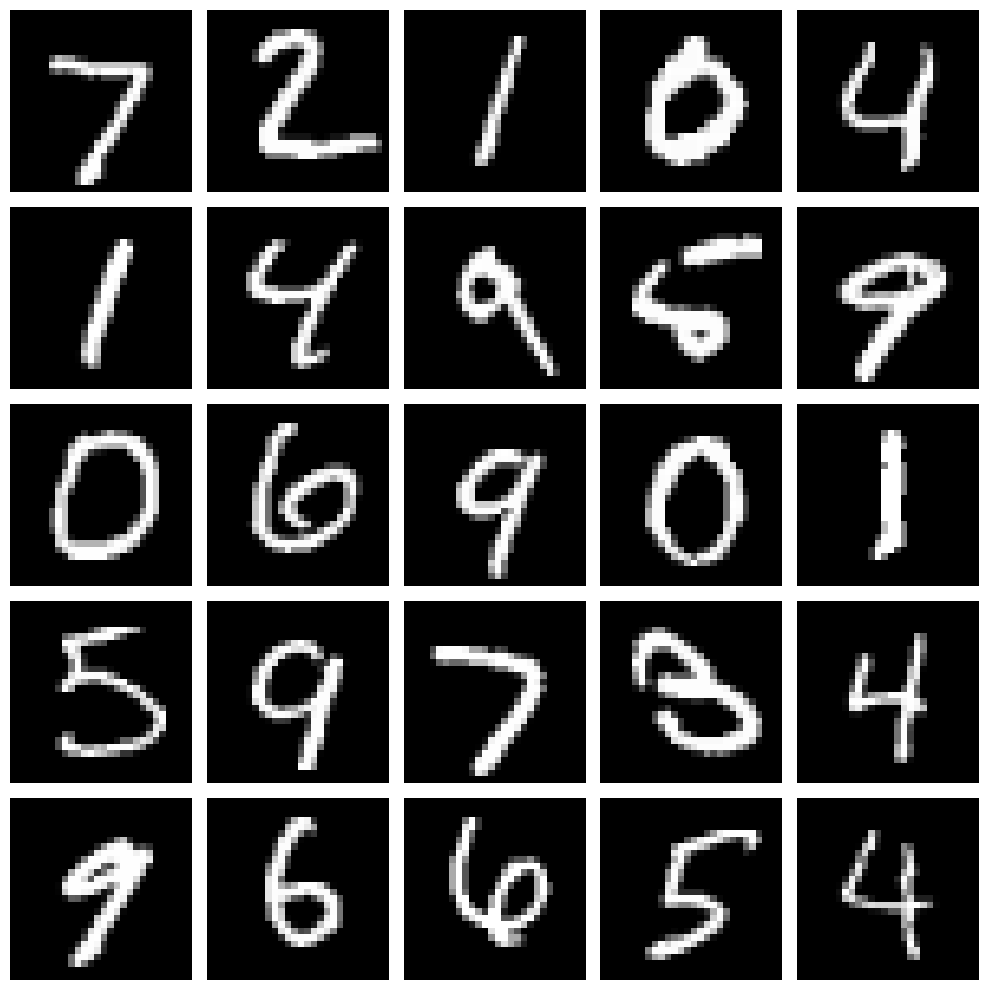

In [30]:
show_image(x, idx=25)

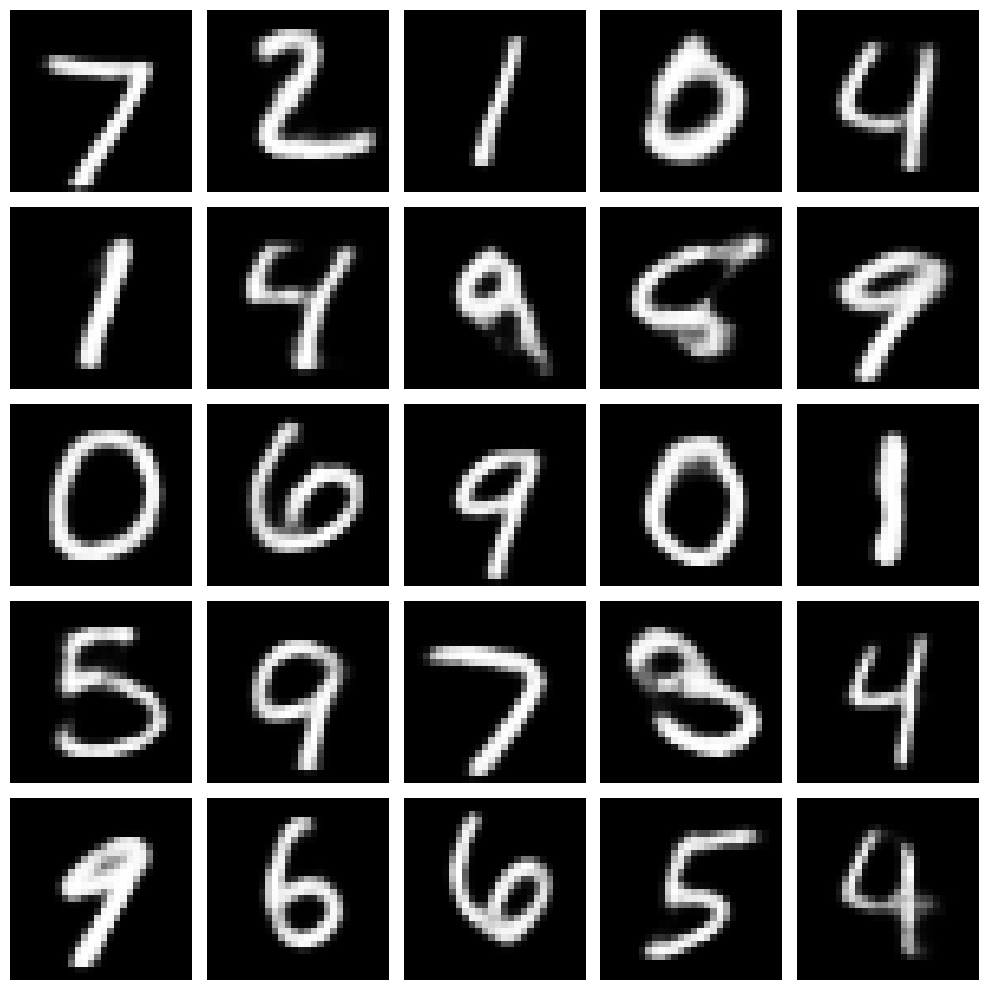

In [31]:
show_image(y_hat, idx=25)

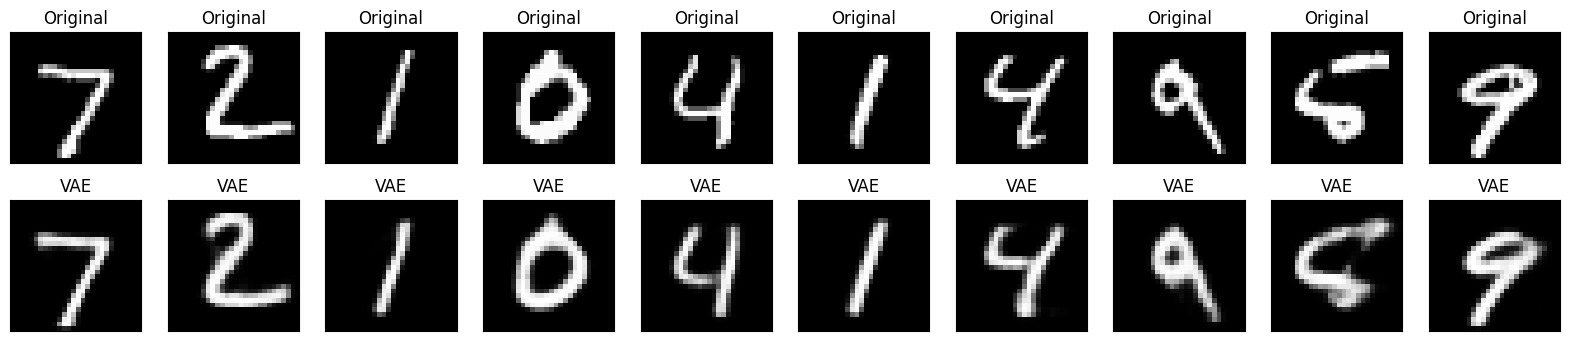

In [32]:
import matplotlib.pyplot as plt
import torch

model.eval() # Coloca o modelo em modo de avaliação
with torch.no_grad():
    # Pega um batch de teste
    for x, _ in test_loader:
        x = x.view(-1, input_channels, altura, largura).to(DEVICE)
        y_hat, _, _ = model(x)
        break

# Plotando os resultados (Original vs Reconstrução)
n = 10  # número de dígitos a exibir
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagem Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i].cpu().reshape(28, 28), cmap='gray')
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagem Reconstruída
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_hat[i].cpu().reshape(28, 28), cmap='gray')
    plt.title("VAE")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()